In [1]:
import  warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import ttest_ind
from IPython.display import display
import statsmodels.stats.api as sms
import matplotlib as mpl
from math import ceil

In [2]:
df_test = pd.read_csv('test_results.csv')
df_user = pd.read_csv('user_table.csv')

In [3]:
df_test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [4]:
df_user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


## Data Cleaning

In [5]:
df_test.isnull().sum()

user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

In [6]:
df_user.isnull().sum()

user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

In [7]:
df = df_test.merge(df_user, how='left', on='user_id')
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


In [8]:
df.isnull().sum()

user_id                 0
timestamp               0
source                  0
device                  0
operative_system        0
test                    0
price                   0
converted               0
city                41184
country             41184
lat                 41184
long                41184
dtype: int64

In [9]:
consistance = df[((df.test==1) & (df.price==59)) | ((df.test==0) & (df.price==39))]
inconsistance1 = df[(df.test==1) & (df.price==39)]
inconsistance0 = df[(df.test==0) & (df.price==59)]
print('test=1, but price=39 count:',len(inconsistance1))
print('test=0, but price=59 count:',len(inconsistance0))

test=1, but price=39 count: 155
test=0, but price=59 count: 210


In [10]:
incon1 = inconsistance1.copy()
incon0 = inconsistance0.copy()
incon1['test'] = incon1['test'].replace(1,0)
incon0['test'] = incon0['test'].replace(0,1)

In [11]:
df_new = pd.concat([incon1,consistance,incon0],axis=0)
df_new['revenue'] = df_new['converted']*df_new['price']
df_new.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
1457,686486,2015-03-28 15:26:19,seo-other,mobile,android,0,39,0,Kennewick,USA,46.20,-119.17,0
1912,128338,2015-05-15 11:41:49,direct_traffic,mobile,android,0,39,0,Los Angeles,USA,34.11,-118.41,0
2337,220590,2015-03-27 12:31:43,ads-google,web,windows,0,39,0,Saint Louis,USA,38.64,-90.24,0
3147,246390,2015-05-30 08:29:44,direct_traffic,mobile,iOS,0,39,0,Bellevue,USA,41.16,-95.92,0
4277,906451,2015-04-05 11:09:18,ads-google,web,windows,0,39,0,West Covina,USA,34.05,-117.91,0


## Q1

In [12]:
print('conversion rate for $59:',len(df_new[((df_new.test==1) & (df_new.converted==1))])/ len(df_new[df_new.test==1]))
print('revenue from $59:',sum(df_new[df_new.test==1].revenue))
print('average revenue:', sum(df_new[df_new.test==1].revenue)/len(df_new[(df_new.test==1)]))
print('--------------------------')
print('conversion rate for $39:',len(df_new[((df_new.test==0) & (df_new.converted==1))])/ len(df_new[df_new.test==0]))
print('revenue from $39:',sum(df_new[df_new.test==0].revenue))
print('average revenue:', sum(df_new[df_new.test==0].revenue)/len(df_new[(df_new.test==0)]))


conversion rate for $59: 0.015570236926959203
revenue from $59: 104843
average revenue: 0.918643978690593
--------------------------
conversion rate for $39: 0.01988927922949396
revenue from $39: 157209
average revenue: 0.7756818899502644


The test with lower price $39 has the higher conversion rate 1.99% and the higher total revenue.\
However, the average revenue for higher price (0.918) is larger than the lower price (0.775).\
\
Use t-test to check
- H0: the average revenue for higher price <= the lower price of the average revenue
- H1: the average revenue for higher price > the lower price of the average revenue

In [13]:
contral = df_new[df_new['test'] == 0]['revenue'].values
experiment = df_new[df_new['test'] == 1]['revenue'].values

In [14]:
#p-value > 0.05：具有方差齊性檢驗
stats.levene(contral,experiment) 

LeveneResult(statistic=39.07408138305981, pvalue=4.0854182019469573e-10)

In [15]:
#沒有方差齊性檢驗，equal_var=False
ttest_ind(contral, experiment, axis=0, equal_var=False)

Ttest_indResult(statistic=-5.770369440939589, pvalue=7.922257729461028e-09)

p-value < 0.05: reject H0\
$59 brings higher average revenue

## Q2

## EDA

In [16]:
print('control group number count:', len(df_new[df_new['test'] == 0]))
print('experimental group number count:', len(df_new[df_new['test'] == 1]))

control group number count: 202672
experimental group number count: 114128


In [25]:
def con_cat_plot(col):
    sns.barplot(x =col, y ='converted', data = df_new, hue ='test')
    plt.xticks(rotation=45)
    plt.show()


----- source ------


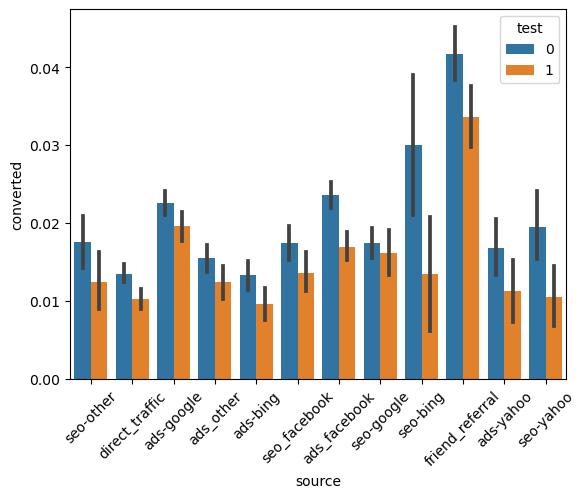

----- device ------


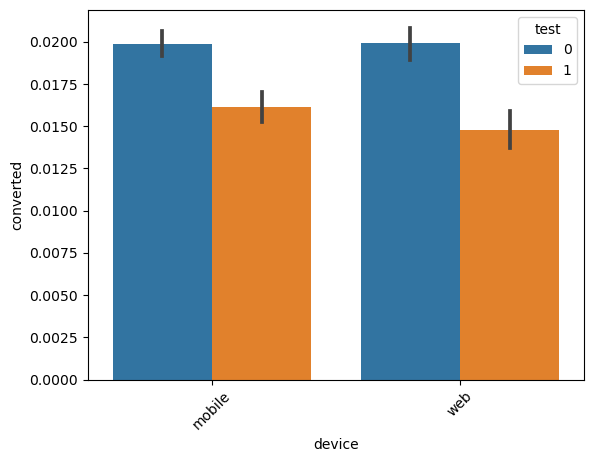

----- operative_system ------


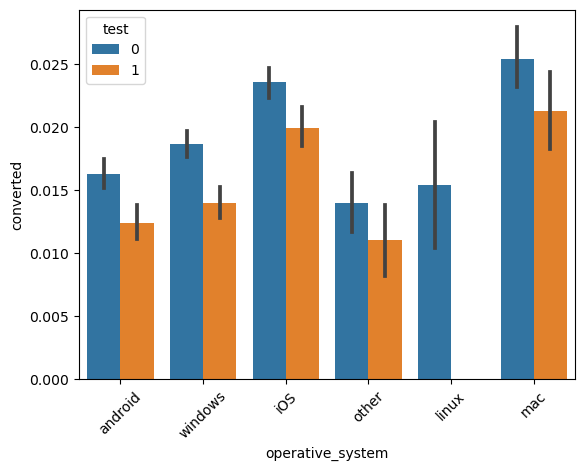

In [26]:
cat_df=("source", "device", "operative_system")
for i in cat_df:
    print('-----',i,'------')
    con_cat_plot(i)

- Lower price has higher convertion rate
- Source: friend refferal has much higher conversion rate than other sources
- Operative system: Apple users (mac and iOS) has higher conversion rate
- linux users never conversted with $59
--------------------------------------------------------
- reward plan for the users who referral their frieds
- launch marketing campain for Apple users

## Q3

AB test 需要幾天 = ( 總共需要多少樣本數量 / 一天能收集多少樣本 ) + 等待事情發生需要幾天

In [19]:
len(df_new)

316800

In [20]:
effect_size = sms.proportion_effectsize(0.015, 0.019)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

16339


In [21]:
max_date = pd.to_datetime(max(df_new['timestamp']), format='%Y/%m/%d')
min_date = pd.to_datetime(min(df_new['timestamp']), format='%Y/%m/%d')
(max_date-min_date).days

90

In [22]:
print('AB teat needs:', (16339*2)/(316800/90), 'days')

AB teat needs: 9.283522727272727 days


Reference
- https://towardsdatascience.com/ab-testing-with-python-e5964dd66143
- https://medium.com/alfredcamera/%E5%81%9A-ab-test-%E9%9C%80%E8%A6%81%E5%A4%9A%E5%B0%91%E6%99%82%E9%96%93-c401fbe00eb0

In [23]:
def cat_plot(col):
    sns.barplot(x =col, y ='revenue', data = df_new, hue ='test')
    plt.ylabel("average revenue")
    plt.xticks(rotation=45)
    plt.show()
    
def ab_testing_random(col):
    ran = df_new.groupby('test')[col].apply(lambda x: x.value_counts(normalize=True)).unstack()
    return ran

----- source ------


,ads-bing,ads-google,ads-yahoo,ads_facebook,ads_other,direct_traffic,friend_referral,seo-bing,seo-google,seo-other,seo-yahoo,seo_facebook
test,,,,,,,,,,,,
0,0.072043,0.186819,0.023772,0.168203,0.095119,0.191196,0.064755,0.006577,0.074510,0.029037,0.021493,0.066477
1,0.072480,0.188525,0.024227,0.169161,0.092861,0.189323,0.066338,0.007185,0.070745,0.029572,0.021835,0.067748


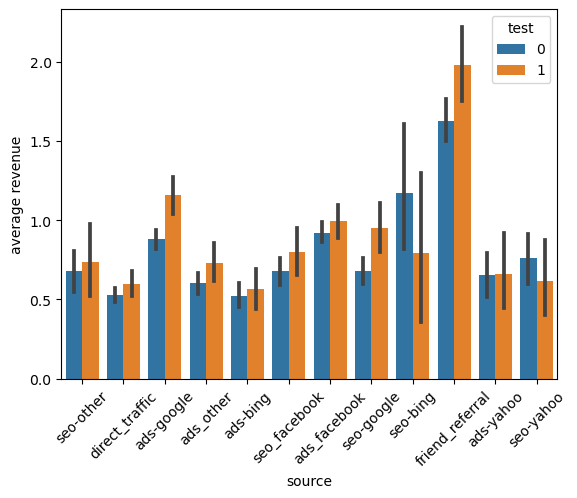

----- device ------


,mobile,web
test,,
0,0.594364,0.405636
1,0.578386,0.421614


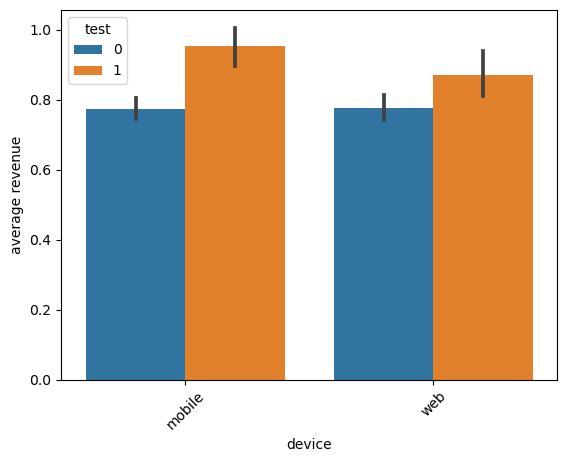

----- operative_system ------


,windows,iOS,android,mac,other,linux
test,,,,,,
0,0.313655,0.305138,0.237867,0.080692,0.051763,0.010885
1,0.327764,0.294599,0.234176,0.076502,0.050058,0.016902


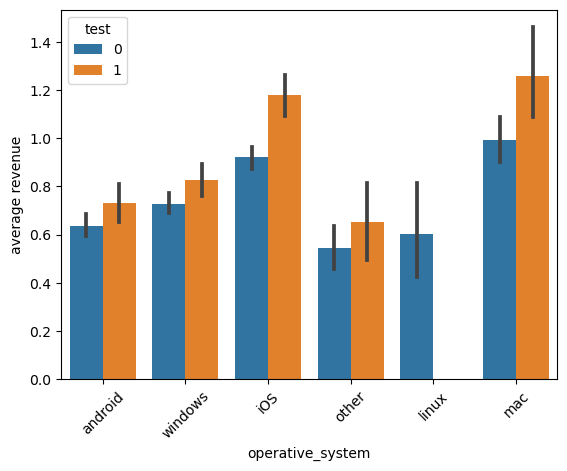

In [24]:
for i in cat_df:
    print('-----',i,'------')
    display(ab_testing_random(i))
    cat_plot(i)

- The test is not totally randomized
- Probably the testing result is not correct 